# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [11]:
# all imports
import time
import pickle
import csv
import operator
from itertools import groupby

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import model_selection

from utils import *

In [12]:
training_file = '../traffic-signs-data/train.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

classes = [i for i in range(44)]

X, Y = train['features'], train['labels']

X_test, y_test = test['features'], test['labels']

In [13]:
names = {}
with open('signnames.csv') as _f:
    rows = csv.reader(_f, delimiter=',')
    next(rows, None)  # skip the headers
    for row in rows:
        names[str(row[0])] = row[1]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

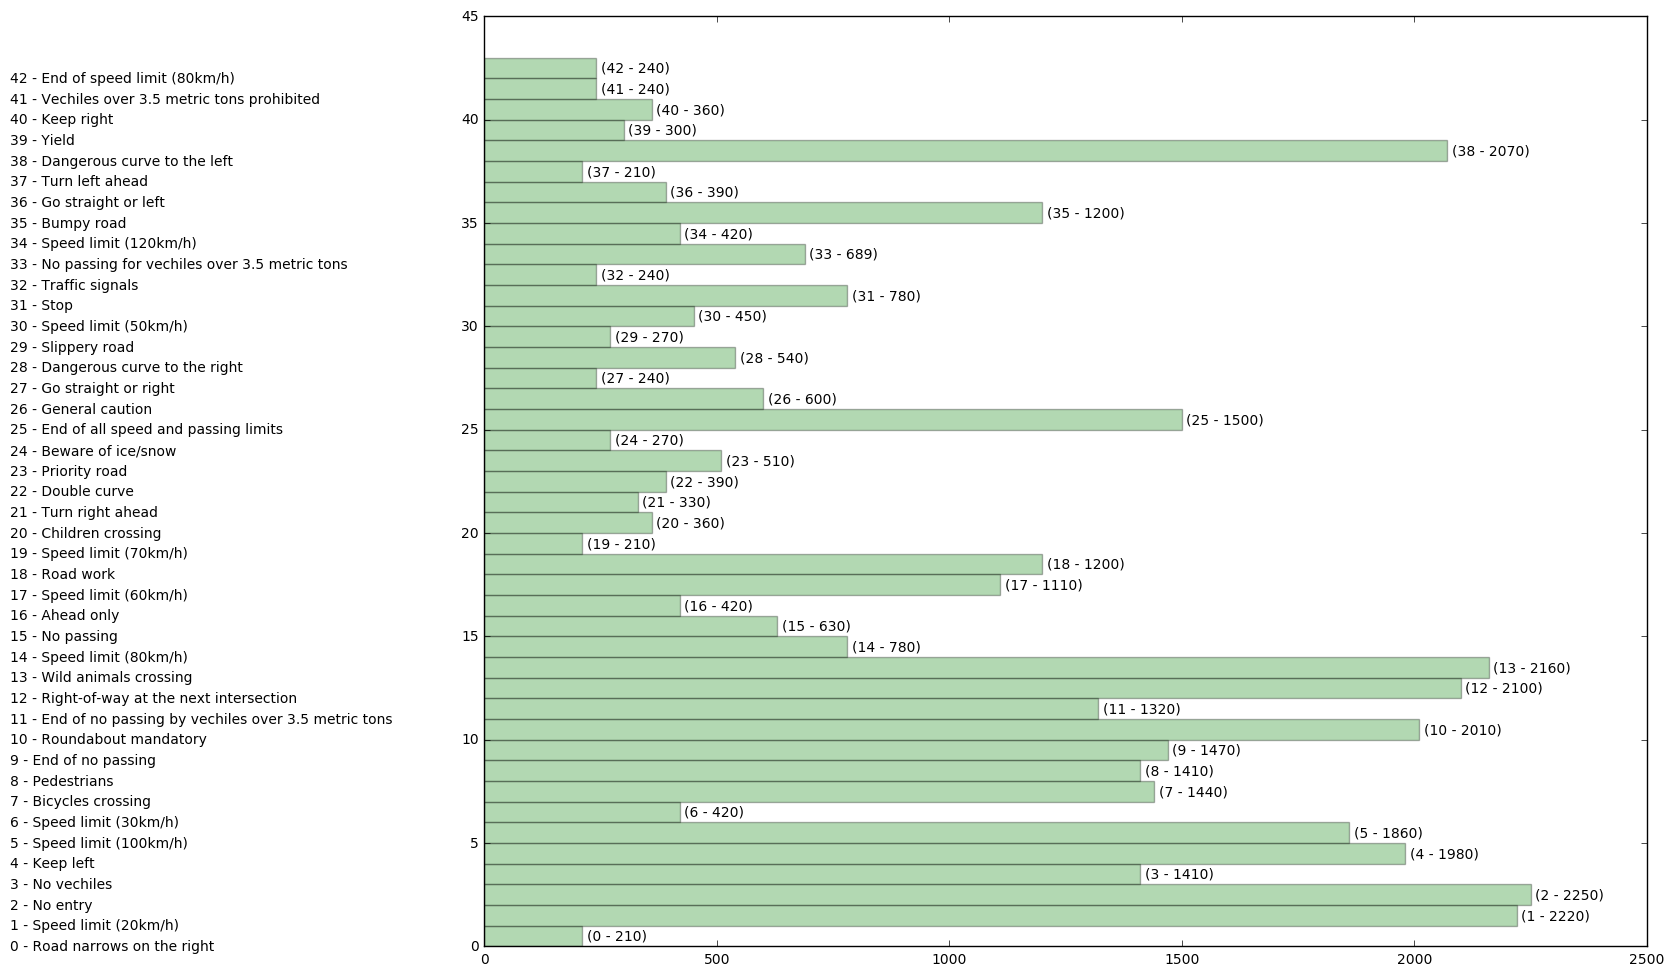

In [14]:
data = group_classes(list(Y))
plot_frequency(list(names.values()), np.array(list(set(Y))), list(data.values()))

In [15]:
X_train = list(X)

Y_train = list(Y)

assert len(X_train) == len(Y_train), 'Unbalanced X, Y lengths'

length = len(X_train)

for i in range(len(X_train)):
    if i % 5000 == 0:
        print("jittering {0} of {1}".format(i, length))
    for j in range(10):
        img = transform_image(X_train[i], 20, 10, 5)
        X_train.append(img)
        Y_train.append(Y_train[j])
        
X_train, Y_train = np.array(X_train), np.array(Y_train)

jittering 0 of 39209
jittering 5000 of 39209
jittering 10000 of 39209
jittering 15000 of 39209
jittering 20000 of 39209
jittering 25000 of 39209
jittering 30000 of 39209
jittering 35000 of 39209


In [16]:
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

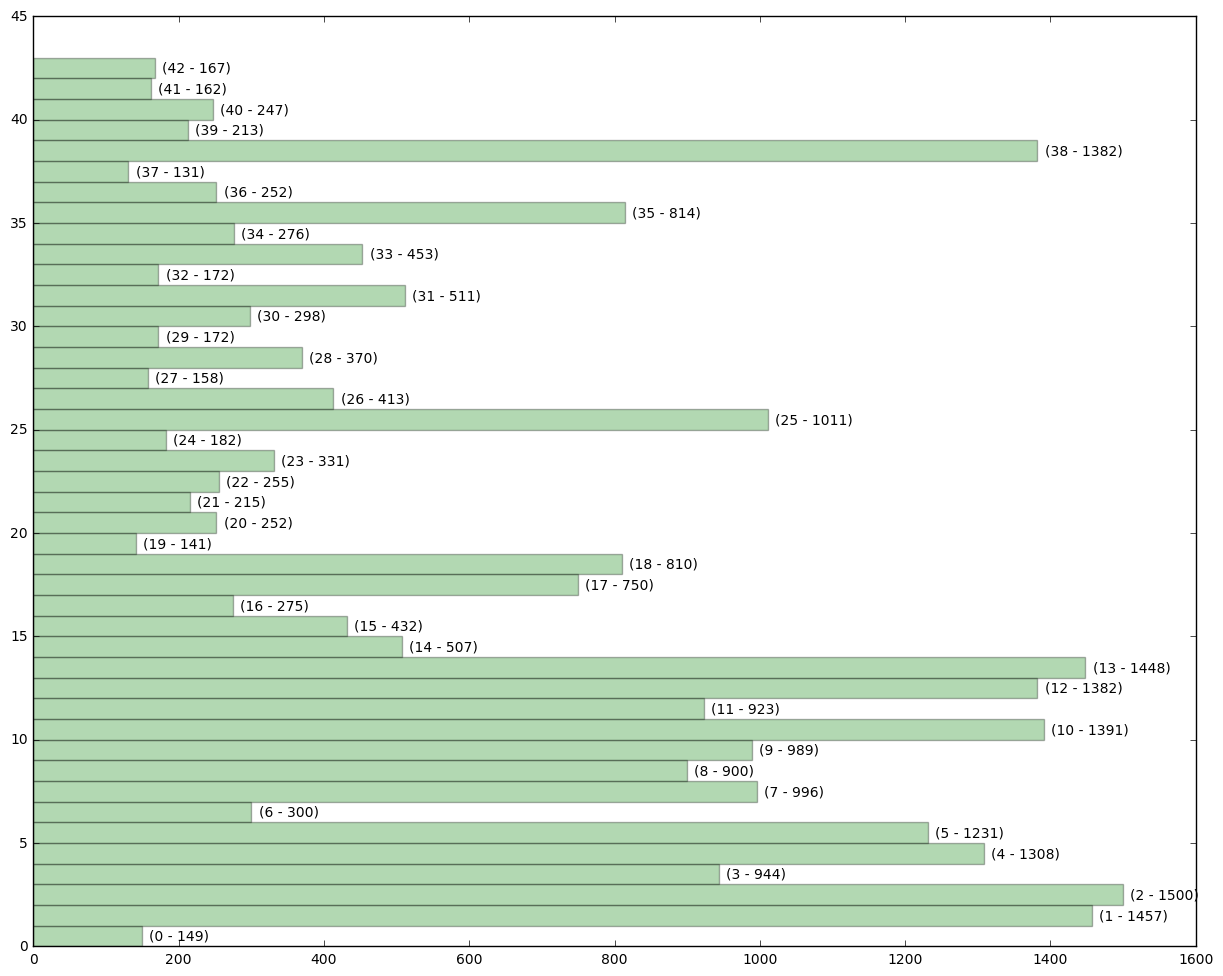

In [17]:
data = group_classes(sorted(Y_train))
plot_frequency(list(names.values()), np.array(list(set(Y))), list(data.values()), with_names=False)

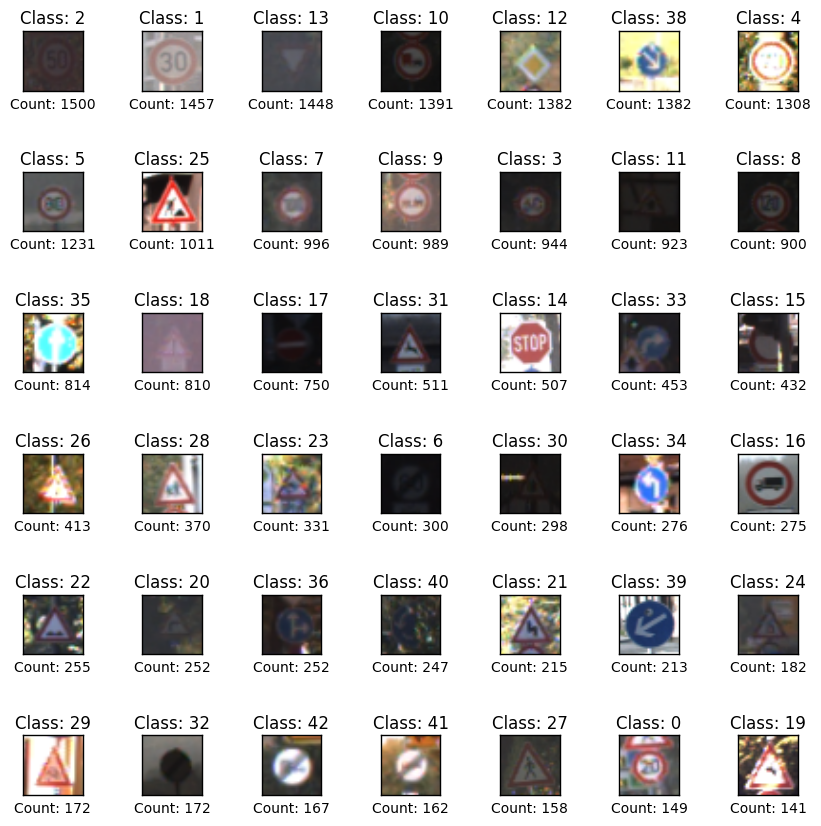

In [18]:
data = group_classes_sorted(sorted(Y_train))
images, labels, counts = get_images_and_counts(X, list(Y), data)
plot_signs(images, labels, counts)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [19]:
print(Y_train[10000])
Y_train = dense_to_one_hot(Y_train, num_classes)

print(Y_train[10000])
Y_val = dense_to_one_hot(Y_val, num_classes)

Y_test =  dense_to_one_hot(y_test, num_classes)

12
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


In [12]:
# Image Tensor
images_placeholder = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x')

gray = tf.image.rgb_to_grayscale(images_placeholder, name='gray')

gray /= 255.

# Label Tensor
labels_placeholder = tf.placeholder(tf.float32, shape=(None, 43), name='y')

# dropout Tensor
keep_prob = tf.placeholder(tf.float32, name='drop')

# construct model
logits = inference(gray, keep_prob)

# calculate loss
loss_value = loss(logits, labels_placeholder)

# training
train_op = training(loss_value, 0.001)

# accuracy
acc = accuracy(logits, labels_placeholder)

saver = tf.train.Saver()

In [13]:
steps = len(X_train) // BATCH_SIZE
    
train_num_examples = steps * BATCH_SIZE

In [14]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    acc_steps = len(X_data) // BATCH_SIZE
    for i in range(acc_steps):
        batch_x, batch_y = next_batch(X_val, Y_val, BATCH_SIZE)
                   
        loss, accuracy = sess.run([loss_value, acc], feed_dict={
                images_placeholder: batch_x,
                labels_placeholder: batch_y,
                keep_prob: 0.5
                })
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return (total_accuracy / num_examples, total_loss / num_examples)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for j in range(steps):
            # train for batch_size
            batch_x, batch_y = next_batch(X_train, Y_train, BATCH_SIZE)
            sess.run(train_op, feed_dict={
                images_placeholder: batch_x,
                labels_placeholder: batch_y,
                keep_prob: 0.5})
            
        val_accuracy, val_loss = evaluate(X_val, Y_val)
        if i % 10 == 0:
            print("EPOCH {} ...".format(i+1))
            print("Validation Loss = {:.3f} and Validation Accuracy = {:.3f}".format(val_loss, val_accuracy*100))
            print()
        
        if val_accuracy > .93:
            break
        
    # for TensorBoard
    summary_op = tf.merge_all_summaries()

    summary_writer = tf.train.SummaryWriter("/home/ubuntu/gtsd-summary", sess.graph)
    save_path = saver.save(sess, '/home/ubuntu/gtsd-12-23-16-final.chkpt')
    print("Model saved in file: %s" % save_path)

Training...

EPOCH 1 ...
Validation Loss = 18.510 and Validation Accuracy = 4.761



In [ ]:
with tf.Session() as sess:
    saver.restore(sess, '/home/ubuntu/gtsd-12-23-16-final.chkpt')
    print("Model restored.")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]*100))

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

For preprocessing I explored several options.  

1) Using RGB

Using RGB only yielded a 70% or so validation accuracy

2) Using YUV

Many of the images are very dark.  I converted the images to YUV and brightened the Y channel but using this same model I was only able to get 88% validation accuracy

3) Just Grayscaling

With the above model and just grayscaling I saw the highest validation accuracy of 93%

All images were of course normalized to reduce computational by dividing each pixel by the value `255`.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Having read LeCuN's paper on this task, I decided to Jitter each image in the dataset to account for potential deformations in the test set.  This improved validation accuracy from 86 to 93%.

To create the validation set, I used Sklearn to take 30% of the test set for validation.  


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**


I used a very simple model to avoid long training durations.  My model consists of one convolutional layer that is `ReLU` activated and maxpooled, one fully connected layer with `512` neurons and a dropout, and a finaly fully connected layer for classification with `fourty three` neurons; the number of classes.

Full Model details are:

1) 1st conv 3x3x32

1.1) 2x2 pooling 

1.2) Stride of 2

2) output: 32x32x32

3) FC: 512

4) dropout : 0.5

    

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

Optimizer: Adam

Epochs: Max of 10000 but I cutt off at 93%

Batch Size: 2500


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I began with a trial and error process which is far too involved for a short answer.  After reading the lecture notes for CS231n, the biggest takeaway for me where the forumulas:

`(W−F+2P)/S+1`

and

`P=(F−1)/2`
 
 Having understood that ConvNets do not fully connect on each layer and only through the depth dimension, I attempted to balance the width and heigths dimensions through the first convolution with a patch of 3, a filter size of 32, a stride of 2, and 2x2 pooling.
 
 This improved my model drastically.  I still had one other implementation issue:  
 
 I pieced together this code from multiple google searches.  At one point I had code which took the softmax, then a few lines of code later used softmax_with_logits.  While this gave reasonable accuracy of 94% I knew it couldn't be trusted because the loss was not reasonable.
 
 Removing the `sofmax` and only using `sofmax_with_logits` solved this problem and I consistently received higher than `92%` with this model on each subsequent trial.
 
 Accuracy on the test set was always above `94.5%` and reached `95.5%` on one trial
 
 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
from PIL import Image
images = os.listdir('./downloaded-images')
images = [cv2.imread('./downloaded-images/'+img) for img in images]

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(3, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
X_test = images
y_test = np.array([19, 40, 39, 14, 16, 10, 3, 31])

In [ ]:
Y_test =  dense_to_one_hot(y_test, num_classes)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, '/home/ubuntu/gtsd-12-23-16-final.chkpt')
    print("Model restored.")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]*100))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, '/home/ubuntu/gtsd-12-23-16-final.chkpt')
    print("Model restored.")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]*100))

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.